In [5]:
# mount drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [24]:
%cd gdrive/MyDrive/graphs/

/content/gdrive/MyDrive/graphs


In [10]:
!pip install cellpylib
import cellpylib as cpl
import numpy as np
import itertools

class CellularAutomataGenerator2D:

  def __init__(self, size_x, size_y, num_states, rule, rule_radius, random_initial_state, simple_initial_state = False):
    if simple_initial_state == True: cellular_automaton = cpl.init_simple2d(size_x, size_y)
    elif random_initial_state == True: cellular_automaton = cpl.init_random2d(size_x, size_y, k = num_states)
    elif random_initial_state == False:
        # Glider
        cellular_automaton = cpl.init_simple2d(60, 60)
        cellular_automaton[:, [28,29,30,30], [30,31,29,31]] = 1

        # Blinker
        cellular_automaton[:, [40,40,40], [15,16,17]] = 1

        # Light Weight Space Ship (LWSS)
        cellular_automaton[:, [18,18,19,20,21,21,21,21,20], [45,48,44,44,44,45,46,47,48]] = 1

    self.cellular_automata = cellular_automaton
    self.rule = rule
    self.rule_radius = rule_radius # rule_radius == 1 for neigbourhoood size of 3x3
    self.nbh_size = rule_radius * 2 + 1
    self.size_x = size_x
    self.size_y = size_y
    self.num_states = num_states

  def proba_rule(self, n, c, t):
    p = 0.5
    out = [0, 1]
    if n[1][1] == 0:
        out = [p**(np.sum(n)), 1 - p**(np.sum(n))]
    return out

  # def proba_rule(self, n, c, t):
  #   string = ""
  #   for row in n:
  #       for elem in row:
  #           string += str(elem)
  #   # print(string)
  #   string = format(int(string, 2), 'b')
  #   # print(string)

  #   out = prob_rule_dict[string]
  #   return out

  def evolve(self, iters):
    self.history = cpl.evolve2d(self.cellular_automata, iters, self.rule, r = self.rule_radius, neighbourhood='Moore', memoize=True)

  def get_iter_data(self, iter_start, iter_end_exclusive):
    return (self.history)[iter_start:iter_end_exclusive]

  def get_all_nbh(self):
    combinations = list(itertools.product(range(self.num_states), repeat=self.nbh_size * self.nbh_size))
    list_of_combinations = [list(x) for x in combinations]
    np_array_of_combinations = [np.reshape(np.array(x), (-1, 3)) for x in list_of_combinations]
    all_nbh = np.stack(np_array_of_combinations, axis=0)
    return all_nbh

  def evaluate_rules(self, nbh_array):
    #nbh_array - numpy array of
    # print(nbh_array.shape)
    rule_vals = []
    for nbh in nbh_array:
      rule_vals.append(self.rule(nbh, (0, 0), 0))
    return np.stack(rule_vals, axis=0)

  def evaluate_rules_proba(self, nbh_array):
    #nbh_array - numpy array of
    # print(nbh_array.shape)
    rule_vals = []
    for nbh in nbh_array:
      rule_vals.append(np.array(self.proba_rule(nbh, (0, 0), 0)))
    # print(rule_vals)
    return np.array(rule_vals)

  def get_nbh_data(self, iter_start, iter_end_exclusive):


    data_raw = self.history[iter_start:iter_end_exclusive+1]



    x_train = np.zeros(shape=(1, self.nbh_size, self.nbh_size), dtype=int) # array: time + nbh_size x nbh_size
    y_train = np.zeros(shape=(1, 1), dtype=int) # array: time + next state from nbh

    for k in range(iter_end_exclusive - iter_start ):
      for i in range(self.size_x):
        for j in range(self.size_y):

          # create array of nbh_size x nbh_size
          # get neighbouring states, pass them to created array
          # get next state from iter
          rows_indices = list()
          nbh = np.zeros((self.nbh_size, self.nbh_size), dtype=int)
          for m in range(-self.rule_radius, self.rule_radius + 1): # i diff
            current_row_indices = list()
            for n in range(-self.rule_radius, self.rule_radius + 1): # j diff
              curr_i = (i + m) % self.size_x
              curr_j = (j + n) % self.size_y
              linear_ind = curr_i * self.size_x + curr_j
              current_row_indices.append(linear_ind)
            rows_indices.append(current_row_indices)
          current_nbh = np.copy(np.take(data_raw[k], rows_indices, mode='raise'))
          x_train = np.concatenate((x_train, np.reshape(current_nbh, (1, self.nbh_size, self.nbh_size))))
          y_train = np.concatenate((y_train, np.reshape(data_raw[k + 1][i][j], (1, 1))))


    return (x_train[1:], y_train[1:])

  def get_distinct_nbh(self, x_train, y_train):

    x_train_flatten = np.reshape(x_train, (x_train.shape[0], x_train.shape[1] * x_train.shape[2]))
    unique_nbh_index = np.unique(x_train_flatten, axis=0, return_index=True)[1]
    x_train_distinct = np.take(x_train, unique_nbh_index, axis=0)

    y_train_distinct = np.take(y_train, unique_nbh_index, axis=0)
    return (x_train_distinct, y_train_distinct)



In [11]:
class CellularAutomataTrainedGenerator:

  def __init__(self, model, num_states, rule_radius, size_x, size_y):
    self.model = model
    self.num_states = num_states
    self.rule_radius = rule_radius
    self.nbh_size = rule_radius * 2 + 1
    self.size_x = size_x
    self.size_y = size_y

  # возвращает состояние клетки по окрестности
  def predict_nbh(self, nbh):

      nbh_reshaped = np.reshape(nbh, (1, nbh.shape[0], nbh.shape[1]))
      return self.model.predict(np.reshape(nbh_reshaped, (nbh_reshaped.shape[0], nbh_reshaped.shape[1] * nbh_reshaped.shape[2])))

  def predict_nbh_proba(self, nbh):

      nbh_reshaped = np.reshape(nbh, (1, nbh.shape[0], nbh.shape[1]))
      proba = self.model.predict_proba(np.reshape(nbh_reshaped, (nbh_reshaped.shape[0], nbh_reshaped.shape[1] * nbh_reshaped.shape[2])))
      return [np.random.choice(proba[0].size, p=proba[0])]

  def predict_rules(self, nbh_array):
    #nbh_array - numpy array of nbh
    rule_vals = []
    for nbh in nbh_array:
      rule_vals.append(self.predict_nbh(nbh))
    return np.stack(rule_vals, axis=0)

  def predict_rules_proba(self, nbh_array):
    #nbh_array - numpy array of nbh
    rule_vals = []
    for nbh in nbh_array:
      nbh_reshaped = np.reshape(nbh, (1, nbh.shape[0], nbh.shape[1]))
      proba = self.model.predict_proba(np.reshape(nbh_reshaped, (nbh_reshaped.shape[0], nbh_reshaped.shape[1] * nbh_reshaped.shape[2])))
      rule_vals.append(proba[0])
    # np.savetxt('proba.txt', np.array(rule_vals))
    # print('rule_vals', rule_vals)
    return np.array(rule_vals)

  # возвращает массив предсказанных состояний размера cnt после входного state
  def next_state(self, ca_state, size_x, size_y, cnt):
    predicted_ca_states = np.zeros((1, size_x, size_y), dtype=int)
    for k in range(cnt):
      next_ca_state = np.zeros((size_x, size_y), dtype=int)
      for i in range(size_x):
        for j in range(size_y):
          nbh = self.get_cell_nbh(ca_state, i, j)
          next_cell_state = self.predict_nbh(nbh)
          next_ca_state[i][j] = next_cell_state[0]
      ca_state = next_ca_state
      predicted_ca_states = np.concatenate((predicted_ca_states, np.reshape(next_ca_state, (1, size_x, size_y))))
    return predicted_ca_states[1:]

      # возвращает массив предсказанных состояний размера cnt после входного state
  def next_state_proba(self, ca_state, size_x, size_y, cnt):
    predicted_ca_states = np.zeros((1, size_x, size_y), dtype=int)
    for k in range(cnt):
      next_ca_state = np.zeros((size_x, size_y), dtype=int)
      for i in range(size_x):
        for j in range(size_y):
          nbh = self.get_cell_nbh(ca_state, i, j)
          next_cell_state = self.predict_nbh_proba(nbh)
          next_ca_state[i][j] = next_cell_state[0]
      ca_state = next_ca_state
      predicted_ca_states = np.concatenate((predicted_ca_states, np.reshape(next_ca_state, (1, size_x, size_y))))
    return predicted_ca_states[1:]


  # возвращает окрестность клетки по индексу и состоянию КА
  def get_cell_nbh(self, ca_state, i, j):
    rows_indices = list()
    for m in range(-self.rule_radius, self.rule_radius + 1): # i diff
      current_row_indices = list()
      for n in range(-self.rule_radius, self.rule_radius + 1): # j diff
        curr_i = (i + m) % self.size_x
        curr_j = (j + n) % self.size_y
        linear_ind = curr_i * self.size_x + curr_j
        current_row_indices.append(linear_ind)
      rows_indices.append(current_row_indices)

    current_nbh = np.copy(np.take(ca_state, rows_indices, mode='raise'))
    return current_nbh

In [12]:

class CellularModelTrainer:

  def __init__(self, model, x_train, y_train):
    self.model = model
    self.x_train = x_train
    self.y_train = y_train.flatten()

  def train(self):
    self.model.fit(self.x_train, self.y_train)

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import time
import math

In [30]:
class CellularAutomataPlotDrawer:
    # real_states, predicted_states - массив [size_x*size_у, num_predicted_iterations, num_expirements]
    # real_rules, predicted_rules - массив [2^rule_radius, num_expirements]
    # num_samples, num_samples_distinct - массив [num_expirements]
    # num_predicted_iterations - фиксированное количество предсказанных итераций
    # num_experements - количество экспериментов, по которым строим графики
    # plot_name - общее в названиях графиков
    def __init__(self, real_states, predicted_states, real_rules, predicted_rules, num_samples, num_samples_distinct, num_predicted_iterations, num_experements, plot_name):
        self.real_states = real_states
        self.predicted_states = predicted_states
        self.real_rules = real_rules
        self.predicted_rules = predicted_rules
        self.num_samples = num_samples
        self.num_samples_distinct = num_samples_distinct
        self.num_predicted_iterations = num_predicted_iterations
        self.num_experements = num_experements
        self.plot_name = plot_name

    def calculate_accuracy (self):
        real_states = self.real_states
        predicted_states = self.predicted_states
        real_rules = self.real_rules
        predicted_rules = self.predicted_rules
        num_samples = self.num_samples
        num_samples_distinct = self.num_samples_distinct
        num_predicted_iterations = self.num_predicted_iterations
        num_experements = self.num_experements
        accuracy = [0 for i in range(len(real_states))]
        for experiment in range(len(real_states)):
            for iteration in range(len(real_states[experiment])):
                sum = 0
                for i in range(len(real_states[experiment][iteration])):
                    sum += math.fabs(real_states[experiment][iteration][i] - predicted_states[experiment][iteration][i])
                sum /= len(real_states[experiment][iteration])
                accuracy[experiment] += sum
            accuracy[experiment] = 1 - accuracy[experiment]/len(real_states[experiment])

        self.accuracy = accuracy
        accuracy_rules = [0 for i in range(num_experements)]
        for experiment in range(num_experements):
            sum = 0
            for i in range(len(real_rules[experiment])):
                sum += math.fabs(real_rules[experiment][i] - predicted_rules[experiment][i])
            sum /= len(real_rules[experiment])
            accuracy_rules[experiment] = 1 - sum
        self.accuracy_rules = accuracy_rules
        print('accuracy_rules')
        print(accuracy_rules)
        accuracy_by_iteration = [0 for i in range(num_predicted_iterations)]
        for iteration in range(num_predicted_iterations):
            sum = 0
            for i in range(len(real_states[-1][iteration])):
                sum += math.fabs(real_states[-1][iteration][i] - predicted_states[-1][iteration][i])
            sum /= len(real_states[-1][iteration])
            accuracy_by_iteration[iteration] = 1 - sum
        self.accuracy_by_iteration = accuracy_by_iteration
    def draw_accuracy_by_samples(self):
        plt.xlabel("Размер обучающей выборки")
        plt.ylabel("Точность")
        plt.title(f"Точность по {self.num_predicted_iterations} итерациям от размера обучающей выборки \n{self.plot_name}")
        # plt.ylim([0, 1])
        plt.plot(self.num_samples, self.accuracy, color='orange', label='randomly initialized game of life automata')
        plt.savefig(f"accuracy_by_samples_{self.plot_name}.pdf", format="pdf")
        plt.show()

    def draw_accuracy_by_samples_distinct(self):
        plt.xlabel("% встреченных правил")
        plt.ylabel("Точность")
        plt.title(f"Точность по {self.num_predicted_iterations} итерациям от % встреченных правил \n{self.plot_name}")
        # plt.ylim([0, 1])
        plt.xlim([self.num_samples_distinct[0] - 10, self.num_samples_distinct[-1] + 10])
        plt.plot(self.num_samples_distinct, self.accuracy, color='orange', label='randomly initialized game of life automata')
        plt.savefig(f"accuracy_by_samples_distinct_{self.plot_name}.pdf", format="pdf")
        plt.show()

    def draw_accuracy_on_rules_by_samples(self):
        plt.xlabel("Размер обучающей выборки")
        plt.ylabel("Точность на правилах")
        plt.title(f"Точность на правилах от размера обучающей выборки \n{self.plot_name}")
        # plt.ylim([0, 1])
        plt.plot(self.num_samples, self.accuracy_rules, color='orange', label='randomly initialized game of life automata')
        plt.savefig(f"accuracy_on_rules_by_samples_{self.plot_name}.pdf", format="pdf")
        plt.show()

    def draw_accuracy_on_rules_by_samples_distinct(self):
        plt.xlabel("% встреченных правил")
        plt.ylabel("Точность на правилах")
        plt.title(f"Точность на правилах от % встреченных правил \n{self.plot_name}")
        # plt.ylim([0, 1])
        plt.xlim([self.num_samples_distinct[0] - 10, self.num_samples_distinct[-1] + 10])
        plt.plot(self.num_samples_distinct, self.accuracy_rules, color='orange', label='randomly initialized game of life automata')
        plt.savefig(f"accuracy_on_rules_by_samples_distinct_{self.plot_name}.pdf", format="pdf")
        plt.show()

    def draw_accuracy_by_iteration(self):
        plt.xlabel("Номер итерации")
        plt.ylabel("Точность")
        plt.title(f"Падение точности с итерациями \n{self.plot_name}")
        # plt.ylim([0, 1])
        plt.plot([i for i in range(1, self.num_predicted_iterations + 1)], self.accuracy_by_iteration, color='orange', label='randomly initialized game of life automata')
        plt.savefig(f"accuracy_by_iteration_{self.plot_name}.pdf", format="pdf")
        plt.show()

    def draw_accuracy_by_samples_aggr(self, num_experiment, labels):
        plt.xlabel("Размер обучающей выборки")
        plt.ylabel("Точность")
        plt.title(f"Точность по {self.num_predicted_iterations} итерациям от размера обучающей выборки \n{self.plot_name}")
        # plt.ylim([0, 1])
        for i in range(num_experiment):
            plt.plot(self.num_samples, self.accuracy[i], label=labels[i])
        plt.legend(loc="upper left")
        plt.savefig(f"accuracy_by_samples_{self.plot_name}_aggr.pdf", format="pdf")
        plt.show()

    def draw_accuracy_by_samples_distinct_aggr(self, num_experiment, labels):
        plt.xlabel("% встреченных правил")
        plt.ylabel("Точность")
        plt.title(f"Точность по {self.num_predicted_iterations} итерациям от % встреченных правил \n{self.plot_name}")
        # plt.ylim([0, 1])
        # plt.xlim([self.num_samples_distinct[0] - 10, self.num_samples_distinct[-1] + 10])
        for i in range(num_experiment):
            plt.plot(self.num_samples_distinct[i], self.accuracy[i], label=labels[i])
        plt.legend(loc="upper left")
        plt.savefig(f"accuracy_by_samples_distinct_{self.plot_name}_aggr.pdf", format="pdf")
        plt.show()

    def draw_accuracy_on_rules_by_samples_aggr(self, num_experiment, labels):
        plt.xlabel("Размер обучающей выборки")
        plt.ylabel("Точность на правилах")
        plt.title(f"Точность на правилах от размера обучающей выборки \n{self.plot_name}")
        # plt.ylim([0, 1])
        for i in range(num_experiment):
            plt.plot(self.num_samples, self.accuracy_rules[i], label=labels[i])
        plt.legend(loc="upper left")
        plt.savefig(f"accuracy_on_rules_by_samples_{self.plot_name}_aggr.pdf", format="pdf")
        plt.show()

    def draw_accuracy_on_rules_by_samples_distinct_aggr(self, num_experiment, labels):
        plt.xlabel("% встреченных правил")
        plt.ylabel("Точность на правилах")
        plt.title(f"Точность на правилах от % встреченных правил \n{self.plot_name}")
        # plt.ylim([0, 1])
        # plt.xlim([self.num_samples_distinct[0] - 10, self.num_samples_distinct[-1] + 10])
        for i in range(num_experiment):
            plt.plot(self.num_samples_distinct[i], self.accuracy_rules[i], label=labels[i])
        plt.legend(loc="upper left")
        plt.savefig(f"accuracy_on_rules_by_samples_distinct_{self.plot_name}_aggr.pdf", format="pdf")
        plt.show()

    def drow_norm_proba(self, norm_proba):
        plt.xlabel("Размер обучающей выборки")
        plt.ylabel("Норма разности вероятностей")
        plt.title(f"Норма разности вероятностей от размера обучающей выборки \n{self.plot_name}")
        # plt.ylim([0, 1])
        plt.plot(self.num_samples, norm_proba, color='orange', label='nondeterministic automata')
        plt.savefig(f"norm_proba_by_samples_{self.plot_name}.pdf", format="pdf")
        plt.show()
        print("norm_proba")
        print(norm_proba)


    def draw_plots(self):
        self.calculate_accuracy()
        self.draw_accuracy_by_samples()
        self.draw_accuracy_by_samples_distinct()
        self.draw_accuracy_on_rules_by_samples()
        self.draw_accuracy_on_rules_by_samples_distinct()
        self.draw_accuracy_by_iteration()

    def draw_plots_proba(self, norm_proba):
        self.calculate_accuracy()
        self.draw_accuracy_by_samples()
        self.draw_accuracy_by_samples_distinct()
        self.draw_accuracy_on_rules_by_samples()
        self.draw_accuracy_on_rules_by_samples_distinct()
        self.drow_norm_proba(norm_proba)
        self.draw_accuracy_by_iteration()

    def draw_plots_avg(self, acc, acc_rules, acc_by_iter, num_samples_distinct):
        self.accuracy = acc
        self.accuracy_rules = acc_rules
        self.accuracy_by_iteration = acc_by_iter
        self.num_samples_distinct = num_samples_distinct
        self.draw_accuracy_by_samples()
        self.draw_accuracy_by_samples_distinct()
        self.draw_accuracy_on_rules_by_samples()
        self.draw_accuracy_on_rules_by_samples_distinct()
        self.draw_accuracy_by_iteration()

    def draw_plots_aggr(self, acc, acc_rules, acc_by_iter, num_samples_distinct, num_experiment, labels):
        self.accuracy = acc
        self.accuracy_rules = acc_rules
        self.accuracy_by_iteration = acc_by_iter
        self.num_samples_distinct = num_samples_distinct
        self.draw_accuracy_by_samples_aggr(num_experiment, labels)
        self.draw_accuracy_by_samples_distinct_aggr(num_experiment, labels)
        self.draw_accuracy_on_rules_by_samples_aggr(num_experiment, labels)
        self.draw_accuracy_on_rules_by_samples_distinct_aggr(num_experiment, labels)


In [15]:
from sklearn.base import clone
class CellularAutomataExperimentator:

    def __init__(self, model, size_x, size_y, num_states, rule, rule_radius, random_initial_state, distinct_training):
        self.model = clone(model)
        self.ca_rule = rule
        self.size_x = size_x
        self.size_y = size_y
        self.num_states = num_states
        self.rule = rule
        self.rule_radius = rule_radius
        self.real_states = []
        self.predicted_states = []
        self.real_rules = []
        self.predicted_rules = []
        self.num_samples = []
        self.num_samples_distinct = []
        self.norm_proba = []
        self.random_initial_state = random_initial_state
        self.distinct_training = distinct_training
        self.ca_gen = CellularAutomataGenerator2D(self.size_x, self.size_y, self.num_states, self.rule, self.rule_radius, self.random_initial_state)



    def run_experiment(self, num_train_iterations, num_predicted_iterations):
        x_train, y_train = self.ca_gen.get_nbh_data(0, num_train_iterations)

        #distinct data to NN
        if self.distinct_training == True:
            x_train, y_train = self.ca_gen.get_distinct_nbh(x_train, y_train)


        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1] * x_train.shape[2]))

        model_for_exp = clone(self.model)
        model_trainer = CellularModelTrainer(model_for_exp, x_train, y_train)
        model_trainer.train()
        trained_generator = CellularAutomataTrainedGenerator(model_for_exp, self.num_states, self.rule_radius, self.size_x, self.size_y)
        initial_state = self.ca_gen.get_iter_data(num_train_iterations - 1, num_train_iterations)

        real_states = self.ca_gen.get_iter_data(num_train_iterations, num_train_iterations + num_predicted_iterations) #надо сдвинуть индекс, т.к. get_iter_data и next_state имеют в аргументах сдвинутые границы
        predicted_states = trained_generator.next_state(initial_state, self.size_x, self.size_y, num_predicted_iterations)

        real_rules = self.ca_gen.evaluate_rules(self.ca_gen.get_all_nbh())
        predicted_rules = trained_generator.predict_rules(self.ca_gen.get_all_nbh()).flatten()
        print('norm ',np.linalg.norm(real_rules - predicted_rules))
        print(x_train.shape)


        # print('initial state')
        # cpl.plot2d(initial_state)
        # print('real state')
        # cpl.plot2d(self.ca_gen.get_iter_data(num_train_iterations, num_train_iterations + 1))
        # print('predicted state')
        # cpl.plot2d(trained_generator.next_state(initial_state, self.size_x, self.size_y, num_train_iterations + 1))

        # раскомментить, чтобы нарисовать все следующие после обучения итерации
        # for i in range(1, num_predicted_iterations):
        #     print(f'predicted_states[{i}]')
        #     cpl.plot2d(trained_generator.next_state(initial_state, self.size_x, self.size_y, i))
        #     print(f'real_states[{i}]')
        #     cpl.plot2d(self.ca_gen.get_iter_data(num_train_iterations + i, num_train_iterations + i + 1))



        real_states = real_states.reshape(real_states.shape[0], -1)

        self.real_states.append(real_states.tolist())

        predicted_states = predicted_states.reshape(predicted_states.shape[0], -1)
        self.predicted_states.append(predicted_states.tolist())


        self.real_rules.append(real_rules.tolist())
        self.predicted_rules.append(predicted_rules.tolist())
        self.num_samples.append(x_train.shape[0])
        self.num_samples_distinct.append(np.unique(x_train, axis=0).shape[0]*100 / (self.num_states**((self.rule_radius*2+1)**2)))
        print(np.unique(x_train, axis=0).shape)

    def run_experiment_model_aggr(self, num_train_iterations, num_predicted_iterations, model):
        x_train, y_train = self.ca_gen.get_nbh_data(0, num_train_iterations)

        #distinct data to NN
        if self.distinct_training == True:
            x_train, y_train = self.ca_gen.get_distinct_nbh(x_train, y_train)


        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1] * x_train.shape[2]))

        model_for_exp = clone(model)
        model_trainer = CellularModelTrainer(model_for_exp, x_train, y_train)
        model_trainer.train()
        trained_generator = CellularAutomataTrainedGenerator(model_for_exp, self.num_states, self.rule_radius, self.size_x, self.size_y)
        initial_state = self.ca_gen.get_iter_data(num_train_iterations - 1, num_train_iterations)

        real_states = self.ca_gen.get_iter_data(num_train_iterations, num_train_iterations + num_predicted_iterations) #надо сдвинуть индекс, т.к. get_iter_data и next_state имеют в аргументах сдвинутые границы
        predicted_states = trained_generator.next_state(initial_state, self.size_x, self.size_y, num_predicted_iterations)

        real_rules = self.ca_gen.evaluate_rules(self.ca_gen.get_all_nbh())
        predicted_rules = trained_generator.predict_rules(self.ca_gen.get_all_nbh()).flatten()

        print('norm ',np.linalg.norm(real_rules - predicted_rules))
        print(x_train.shape)



        # раскомментить, чтобы нарисовать все следующие после обучения итерации
        # for i in range(1, num_predicted_iterations):
        #     print(f'predicted_states[{i}]')
        #     cpl.plot2d(trained_generator.next_state(initial_state, self.size_x, self.size_y, i))
        #     print(f'real_states[{i}]')
        #     cpl.plot2d(self.ca_gen.get_iter_data(num_train_iterations + i, num_train_iterations + i + 1))


        real_states = real_states.reshape(real_states.shape[0], -1)

        self.real_states.append(real_states.tolist())

        predicted_states = predicted_states.reshape(predicted_states.shape[0], -1)
        self.predicted_states.append(predicted_states.tolist())


        self.real_rules.append(real_rules.tolist())

        self.predicted_rules.append(predicted_rules.tolist())
        self.num_samples.append(x_train.shape[0])
        self.num_samples_distinct.append(np.unique(x_train, axis=0).shape[0]*100 / (self.num_states**((self.rule_radius*2+1)**2)))
        print(np.unique(x_train, axis=0).shape)

    def run_experiment_proba(self, num_train_iterations, num_predicted_iterations):
        x_train, y_train = self.ca_gen.get_nbh_data(0, num_train_iterations)

        #distinct data to NN
        if self.distinct_training == True:
            x_train, y_train = self.ca_gen.get_distinct_nbh(x_train, y_train)


        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1] * x_train.shape[2]))

        model_for_exp = clone(self.model)
        model_trainer = CellularModelTrainer(model_for_exp, x_train, y_train)
        model_trainer.train()
        trained_generator = CellularAutomataTrainedGenerator(model_for_exp, self.num_states, self.rule_radius, self.size_x, self.size_y)
        initial_state = self.ca_gen.get_iter_data(num_train_iterations - 1, num_train_iterations)

        real_states = self.ca_gen.get_iter_data(num_train_iterations, num_train_iterations + num_predicted_iterations) #надо сдвинуть индекс, т.к. get_iter_data и next_state имеют в аргументах сдвинутые границы
        predicted_states = trained_generator.next_state_proba(initial_state, self.size_x, self.size_y, num_predicted_iterations)

        real_rules = self.ca_gen.evaluate_rules(self.ca_gen.get_all_nbh())
        real_rules_proba = self.ca_gen.evaluate_rules_proba(self.ca_gen.get_all_nbh())

        predicted_rules = trained_generator.predict_rules(self.ca_gen.get_all_nbh()).flatten()
        predicted_rules_proba = trained_generator.predict_rules_proba(self.ca_gen.get_all_nbh())

        # print('norm ',np.linalg.norm(real_rules - predicted_rules))
        # print(x_train.shape)

        # print('real_rules_proba\n', real_rules_proba)
        # print('predicted_rules_proba\n', predicted_rules_proba)
        norm_proba = np.linalg.norm(real_rules_proba[0,:] - predicted_rules_proba[0,:])
        # print('norm_proba ',norm_proba)


        # print('initial state')
        cpl.plot2d(initial_state)
        # print('real state')
        cpl.plot2d(self.ca_gen.get_iter_data(num_train_iterations, num_train_iterations + 1))
        # print('predicted state')
        cpl.plot2d(trained_generator.next_state_proba(initial_state, self.size_x, self.size_y, num_train_iterations))

        # раскомментить, чтобы нарисовать все следующие после обучения итерации
        # for i in range(1, num_predicted_iterations):
        #     print(f'predicted_states[{i}]')
        #     cpl.plot2d(trained_generator.next_state(initial_state, self.size_x, self.size_y, i))
        #     print(f'real_states[{i}]')
        #     cpl.plot2d(self.ca_gen.get_iter_data(num_train_iterations + i, num_train_iterations + i + 1))



        real_states = real_states.reshape(real_states.shape[0], -1)

        self.real_states.append(real_states.tolist())

        predicted_states = predicted_states.reshape(predicted_states.shape[0], -1)
        self.predicted_states.append(predicted_states.tolist())


        self.real_rules.append(real_rules.tolist())

        self.predicted_rules.append(predicted_rules.tolist())
        self.num_samples.append(x_train.shape[0])
        self.num_samples_distinct.append(np.unique(x_train, axis=0).shape[0]*100 / (self.num_states**((self.rule_radius*2+1)**2)))
        self.norm_proba.append(norm_proba)
        print(np.unique(x_train, axis=0).shape)

    def experimentate(self, num_train_iterations, num_predicted_iterations, plot_name):
        self.real_states = []
        self.predicted_states = []
        self.real_rules = []
        self.predicted_rules = []
        self.num_samples = []
        self.num_samples_distinct = []

        self.ca_gen = CellularAutomataGenerator2D(self.size_x, self.size_y, self.num_states, self.rule, self.rule_radius, self.random_initial_state)

        num_experements = len(num_train_iterations)
        for i in range(len(num_train_iterations)):
            # print('Experiment ', i)
            self.ca_gen.evolve(num_train_iterations[i] + num_predicted_iterations + 1)
            self.run_experiment(num_train_iterations[i], num_predicted_iterations)
        plot_drawer = CellularAutomataPlotDrawer(
            self.real_states,
            self.predicted_states,
            self.real_rules,
            self.predicted_rules,
            self.num_samples,
            self.num_samples_distinct,
            num_predicted_iterations,
            num_experements,
            plot_name)
        plot_drawer.draw_plots()

    def experimentate_proba(self, num_train_iterations, num_predicted_iterations, plot_name, simple_initial_state = False):
        self.real_states = []
        self.predicted_states = []
        self.real_rules = []
        self.predicted_rules = []
        self.num_samples = []
        self.num_samples_distinct = []
        self.norm_proba = []

        self.ca_gen = CellularAutomataGenerator2D(
            self.size_x,
            self.size_y,
            self.num_states,
            self.rule,
            self.rule_radius,
            self.random_initial_state,
            simple_initial_state)

        num_experements = len(num_train_iterations)
        for i in range(len(num_train_iterations)):
            # print('Experiment ', i)
            self.ca_gen.evolve(num_train_iterations[i] + num_predicted_iterations + 1)
            self.run_experiment_proba(num_train_iterations[i], num_predicted_iterations)
        plot_drawer = CellularAutomataPlotDrawer(self.real_states, self.predicted_states, self.real_rules, self.predicted_rules, self.num_samples, self.num_samples_distinct, num_predicted_iterations, num_experements, plot_name)
        plot_drawer.draw_plots_proba(self.norm_proba)

    def experimentate_average(self, num_train_iterations, num_predicted_iterations, num_avg, plot_name):
        self.real_states = []
        self.predicted_states = []
        self.real_rules = []
        self.predicted_rules = []
        self.num_samples = []
        self.num_samples_distinct = []

        acc = []
        acc_rules = []
        acc_by_iter = []
        num_samples_distinct_avg = []


        num_experements = len(num_train_iterations)
        for j in range(num_avg):
            self.ca_gen = CellularAutomataGenerator2D(self.size_x, self.size_y, self.num_states, self.rule, self.rule_radius, self.random_initial_state)

            self.real_states = []
            self.predicted_states = []
            self.real_rules = []
            self.predicted_rules = []
            self.num_samples = []
            self.num_samples_distinct = []
            for i in range(len(num_train_iterations)):
                # print('Experiment ', i)
                self.ca_gen.evolve(num_train_iterations[i] + num_predicted_iterations + 1)
                self.run_experiment(num_train_iterations[i], num_predicted_iterations)


            plot_drawer = CellularAutomataPlotDrawer(self.real_states, self.predicted_states, self.real_rules, self.predicted_rules, self.num_samples, self.num_samples_distinct, num_predicted_iterations, num_experements, plot_name)
            plot_drawer.calculate_accuracy()
            acc.append(plot_drawer.accuracy)
            acc_rules.append(plot_drawer.accuracy_rules)
            acc_by_iter.append(plot_drawer.accuracy_by_iteration)
            num_samples_distinct_avg.append(plot_drawer.num_samples_distinct)
        acc = np.mean(acc, axis=0).tolist()
        acc_rules = np.mean(acc_rules, axis=0).tolist()
        acc_by_iter = np.mean(acc_by_iter, axis=0).tolist()
        num_samples_distinct_avg = np.mean(num_samples_distinct_avg, axis=0).tolist()
        plot_drawer.draw_plots_avg(acc, acc_rules, acc_by_iter, num_samples_distinct_avg)

    def experimentate_aggr(self, num_train_iterations, num_predicted_iterations, num_experiment, plot_name, labels):
        self.real_states = []
        self.predicted_states = []
        self.real_rules = []
        self.predicted_rules = []
        self.num_samples = []
        self.num_samples_distinct = []

        acc = []
        acc_rules = []
        acc_by_iter = []
        num_samples_distinct_avg = []


        num_experements = len(num_train_iterations)
        for j in range(num_experiment):
            self.ca_gen = CellularAutomataGenerator2D(self.size_x, self.size_y, self.num_states, self.rule, self.rule_radius, self.random_initial_state)

            self.real_states = []
            self.predicted_states = []
            self.real_rules = []
            self.predicted_rules = []
            self.num_samples = []
            self.num_samples_distinct = []
            for i in range(len(num_train_iterations)):
                # print('Experiment ', i)
                self.ca_gen.evolve(num_train_iterations[i] + num_predicted_iterations + 1)
                self.run_experiment(num_train_iterations[i], num_predicted_iterations)


            plot_drawer = CellularAutomataPlotDrawer(self.real_states, self.predicted_states, self.real_rules, self.predicted_rules, self.num_samples, self.num_samples_distinct, num_predicted_iterations, num_experements, plot_name)
            plot_drawer.calculate_accuracy()
            acc.append(plot_drawer.accuracy)
            acc_rules.append(plot_drawer.accuracy_rules)
            acc_by_iter.append(plot_drawer.accuracy_by_iteration)
            num_samples_distinct_avg.append(plot_drawer.num_samples_distinct)
        # acc = np.mean(acc, axis=0).tolist()
        # acc_rules = np.mean(acc_rules, axis=0).tolist()
        # acc_by_iter = np.mean(acc_by_iter, axis=0).tolist()
        # num_samples_distinct_avg = np.mean(num_samples_distinct_avg, axis=0).tolist()
        plot_drawer.draw_plots_aggr(acc, acc_rules, acc_by_iter, num_samples_distinct_avg, num_experiment, labels)

    def experimentate_model_aggr(self, num_train_iterations, num_predicted_iterations, num_experiment, plot_name, models, labels):
        self.real_states = []
        self.predicted_states = []
        self.real_rules = []
        self.predicted_rules = []
        self.num_samples = []
        self.num_samples_distinct = []

        acc = []
        acc_rules = []
        acc_by_iter = []
        num_samples_distinct_avg = []


        num_experements = len(num_train_iterations)
        for j in range(num_experiment):
            self.ca_gen = CellularAutomataGenerator2D(
                self.size_x,
                self.size_y,
                self.num_states,
                self.rule,
                self.rule_radius,
                self.random_initial_state)

            self.real_states = []
            self.predicted_states = []
            self.real_rules = []
            self.predicted_rules = []
            self.num_samples = []
            self.num_samples_distinct = []
            for i in range(len(num_train_iterations)):
                # print('Experiment ', i)
                self.ca_gen.evolve(num_train_iterations[i] + num_predicted_iterations + 1)
                self.run_experiment_model_aggr(num_train_iterations[i], num_predicted_iterations, models[j])


            plot_drawer = CellularAutomataPlotDrawer(
                self.real_states,
                self.predicted_states,
                self.real_rules,
                self.predicted_rules,
                self.num_samples,
                self.num_samples_distinct,
                num_predicted_iterations,
                num_experements,
                plot_name)
            plot_drawer.calculate_accuracy()
            acc.append(plot_drawer.accuracy)
            acc_rules.append(plot_drawer.accuracy_rules)
            acc_by_iter.append(plot_drawer.accuracy_by_iteration)
            num_samples_distinct_avg.append(plot_drawer.num_samples_distinct)
        # acc = np.mean(acc, axis=0).tolist()
        # acc_rules = np.mean(acc_rules, axis=0).tolist()
        # acc_by_iter = np.mean(acc_by_iter, axis=0).tolist()
        # num_samples_distinct_avg = np.mean(num_samples_distinct_avg, axis=0).tolist()
        plot_drawer.draw_plots_aggr(acc, acc_rules, acc_by_iter, num_samples_distinct_avg, num_experiment, labels)


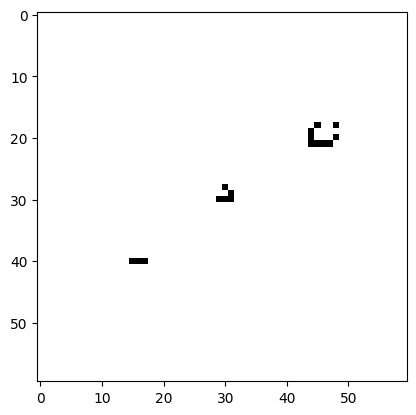

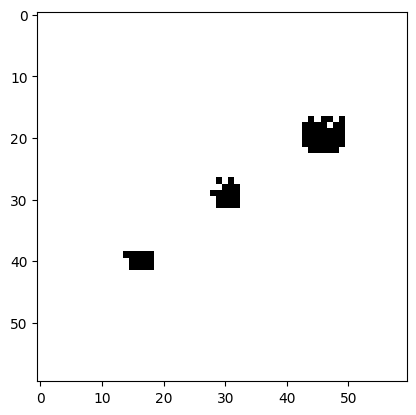

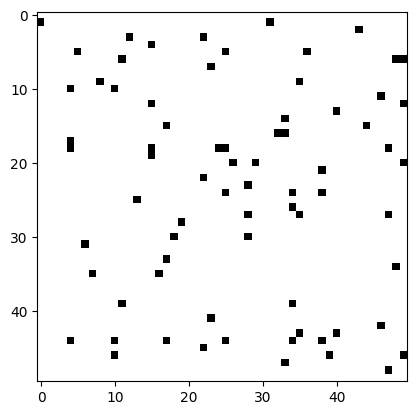

(19, 9)


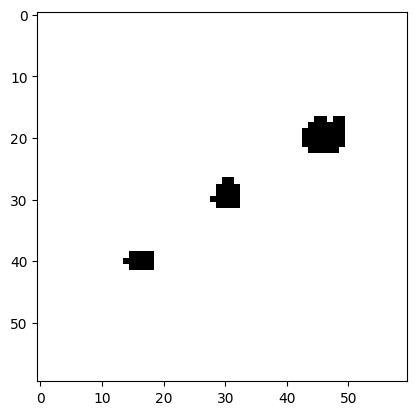

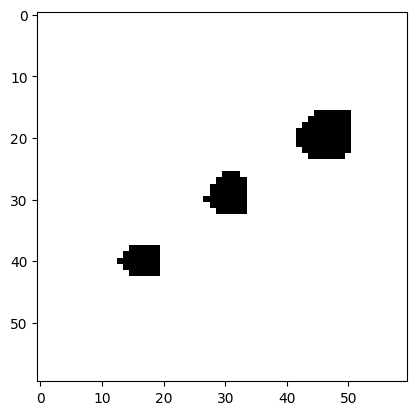

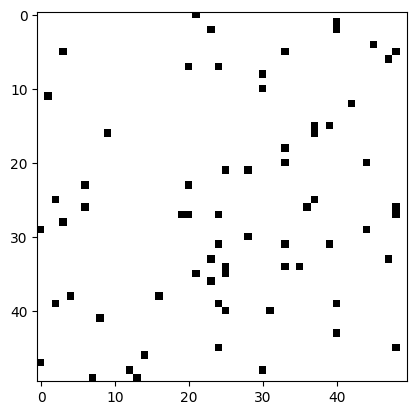

(22, 9)


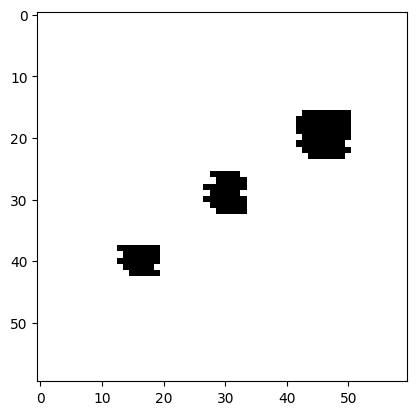

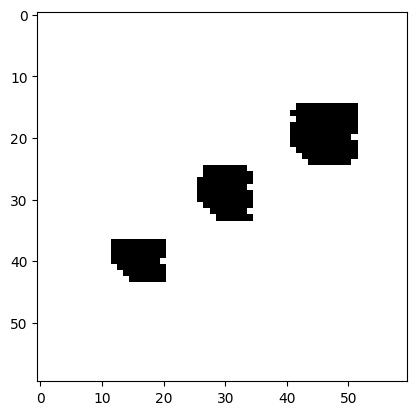

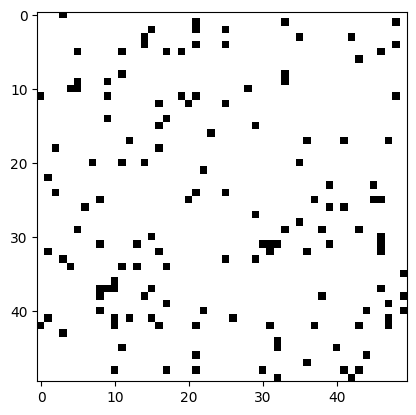

(29, 9)


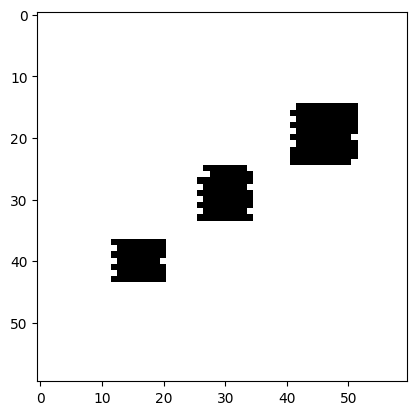

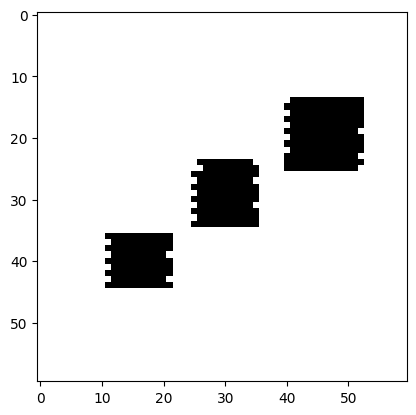

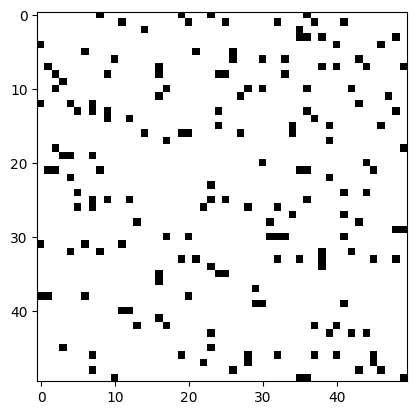

(55, 9)


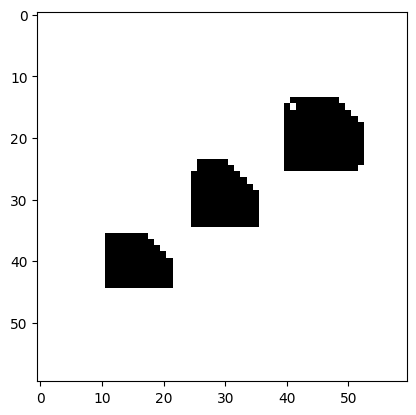

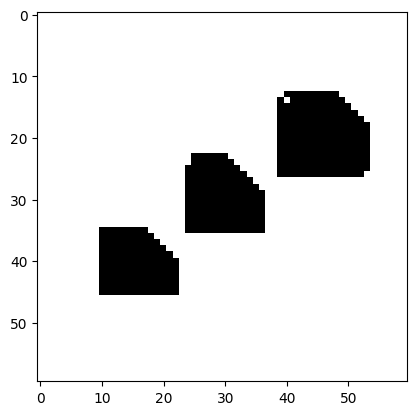

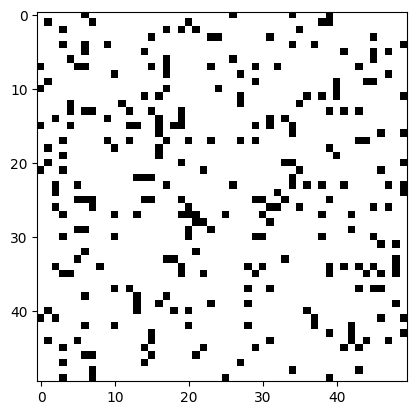

(81, 9)


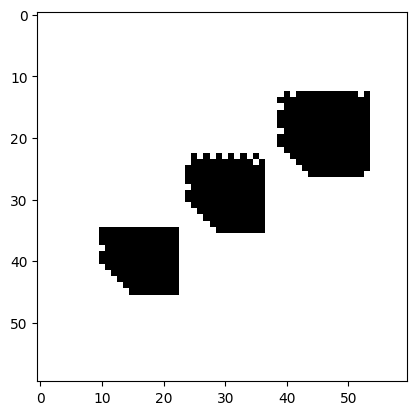

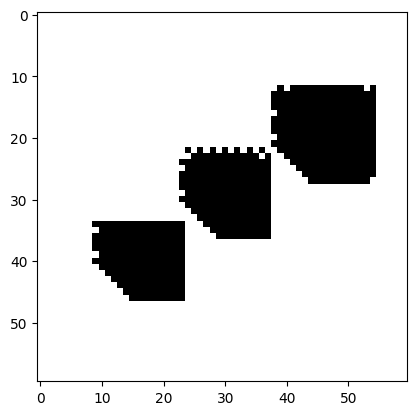

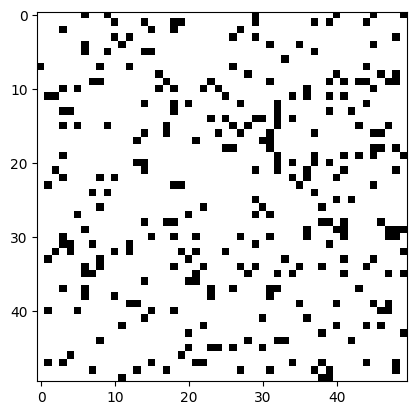

(123, 9)


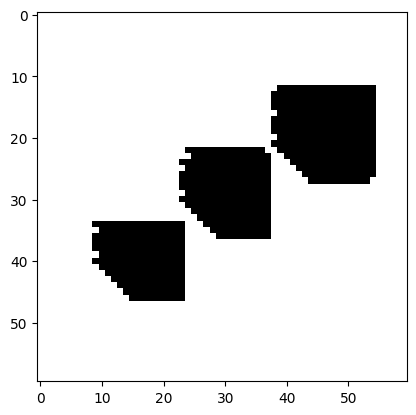

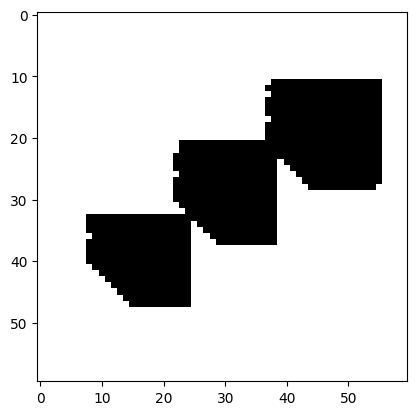

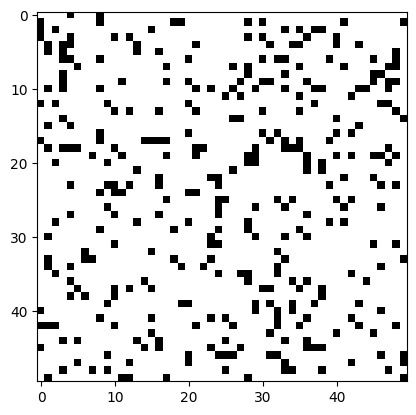

(91, 9)


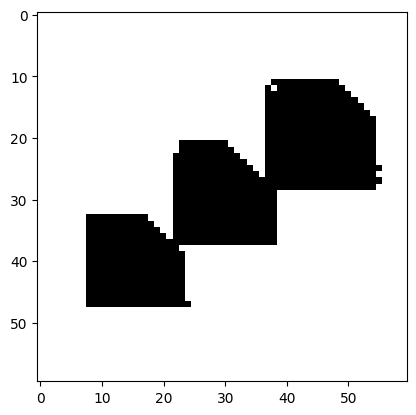

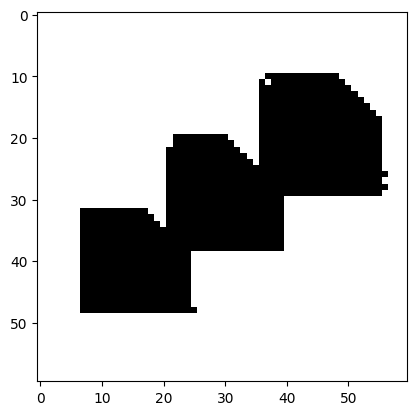

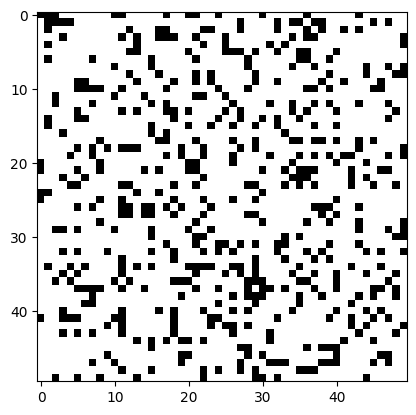

(120, 9)


IndexError: list index out of range

In [54]:
%%time
# простой недетерминированный автомат, распространение эпидемии

from sklearn.neural_network import MLPClassifier
from random import choices
def probability_rule(n, c, t):
    p = 0.25
    out = 1
    if n[1][1] == 0:
        out = choices([0,1], [p**(np.sum(n)), 1 - p**(np.sum(n))])[0]
    return out

clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(9, 9), max_iter = 10000) # убрал random_state = 1
experimentator = CellularAutomataExperimentator(clf, 50, 50, 2, probability_rule, 1, random_initial_state=False, distinct_training=False)
experimentator.experimentate_proba([1, 2, 3, 4, 5, 6, 7, 8], 10, 'Epidemic cellular automata')

In [ ]:
# # генерация случайных правил для детерминированного автомата
# from random import choices, uniform

# prob_rule_dict = {}

# for i in range(2**9):
#     string = format(i, 'b')
#     p = uniform(0, 1)
#     prob_rule_dict[string] = [p, 1-p]

# def probability_rule_dict(n, c, t):
#     string = ""
#     for row in n:
#         for elem in row:
#             string += str(elem)
#     string = format(int(string, 2), 'b')
#     out = choices([0,1], prob_rule_dict[string])[0]
#     return out

In [ ]:
# # генерация случайных правил для недетерминированного автомата НЕ РАБОТАЕТ КОРРЕКТНО Т.К. ЗАХАРДКОЖЕНО
# from random import choices, uniform

# prob_rule_dict = {}

# for i in range(2**9):
#     if i > 256:
#         string = format(i, 'b')
#         p = uniform(0, 1)
#         prob_rule_dict[string] = [p, 1-p]
#     else:
#         string = format(i, 'b')
#         p = uniform(0, 1)**4
#         prob_rule_dict[string] = [1-p, p]

In [ ]:
# %%time
# # запуск для случайно сгенерированных правил, недетерминированный автомат НЕ РАБОТАЕТ КОРРЕКТНО Т.К. ЗАХАРДКОЖЕНО

# from sklearn.neural_network import MLPClassifier
# from random import choices, uniform



# print(prob_rule_dict)

# def probability_rule_dict(n, c, t):
#     string = ""
#     for row in n:
#         for elem in row:
#             string += str(elem)
#     # print(string)
#     string = format(int(string, 2), 'b')
#     # print(string)

#     out = choices([0,1], prob_rule_dict[string])[0]
#     return out

# clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(9, 9), max_iter = 10000) # убрал random_state = 1
# experimentator = CellularAutomataExperimentator(clf, 60, 60, 2, probability_rule_dict, 1, random_initial_state=False, distinct_training=False)
# experimentator.experimentate_proba([2, 3, 4, 5, 6, 7, 8], 10, 'test_proba')

In [26]:
!pwd

/content/gdrive/MyDrive/graphs


In [ ]:
%%time
#запуск для рисования нескольких случаев начального состояния для игры Жизнь
clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(9, 9), max_iter = 10000) # убрал random_state = 1
experimentator = CellularAutomataExperimentator(clf, 10, 10, 2, cpl.game_of_life_rule, 1, random_initial_state=True, distinct_training=True)
experimentator.experimentate_aggr([2, 3, 4, 5, 6], 10, 3, 'test_aggr')

In [ ]:
%%time
# запуск с усреднением для другого детерминированного автомата


from sklearn.neural_network import MLPClassifier
def copy_rule(n, c, t):
  return np.sum(n)%2

clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(9, 9), max_iter = 10000) # убрал random_state = 1
experimentator = CellularAutomataExperimentator(clf, 60, 60, 2, copy_rule, 1, random_initial_state=False, distinct_training=False)
experimentator.experimentate_average([2, 5, 10, 20, 40],3 ,2 , 'test_avg')

In [ ]:
%%time
# запуск с усреднением для игры Жизнь (везде убрал random_state, если передать, то результат работы моделей будет детерминированным)


from sklearn.neural_network import MLPClassifier
def copy_rule(n, c, t):
  return np.sum(n)%2

clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(9, 9), max_iter = 10000) # убрал random_state = 1
experimentator = CellularAutomataExperimentator(clf, 10, 10, 2, cpl.game_of_life_rule, 1, random_initial_state=True, distinct_training=True)
experimentator.experimentate_average([2,3,4,5,6,7,8],10 ,20 , 'test_avg')

In [ ]:
%%time
# запуск без усреднения для картинки 60 на 60 из примера для игры Жизнь


from sklearn.neural_network import MLPClassifier
def const_rule(n, c, t):
  return 1

clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(9, 9), max_iter = 10000, random_state = 8)
experimentator = CellularAutomataExperimentator(clf, 60, 60, 2, cpl.game_of_life_rule, 1, random_initial_state=False, distinct_training=False)
experimentator.experimentate([2, 3, 4], 10, 'test')

In [ ]:
%%time
# запуск без усреднения для случайного начального состояния для игры Жизнь


from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(9, 9), max_iter = 10000)
experimentator = CellularAutomataExperimentator(clf, 5, 5, 2, cpl.game_of_life_rule, 1, random_initial_state=True, distinct_training=False)
experimentator.experimentate([2, 3, 4], 10, 'test')

In [ ]:
%%time
# запуск с усреднением для метода k случайных соседей для случайного начального состояния


from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=10)
experimentator = CellularAutomataExperimentator(clf, 10, 10, 2, cpl.game_of_life_rule, 1, random_initial_state=True, distinct_training=True)
experimentator.experimentate_average([2, 4, 6, 8, 10], 10, 5, 'test')

In [ ]:
%%time
# запуск без усреднения для RandomForestClassifier для случайного начального состояния (долго работает при дефолтном параметре n_estimators = 100; n_jobs - кол-во используемых ядер, можно использовать для распараллеливания и в других моделях)


from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 10, max_depth=2, random_state=0, n_jobs = 1)
experimentator = CellularAutomataExperimentator(clf, 10, 10, 2, cpl.game_of_life_rule, 1, random_initial_state=True, distinct_training=True)
experimentator.experimentate([2, 4, 6, 8, 10, 20], 10, 'test')

In [ ]:
%%time
# запуск с усреднением для DecisionTreeClassifier для случайного начального состояния (самое быстрое и самые лучшие графики!)


from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
experimentator = CellularAutomataExperimentator(clf, 10, 10, 2, cpl.game_of_life_rule, 1, random_initial_state=True, distinct_training=True)
experimentator.experimentate_average([2, 4, 6, 8, 10, 20], 10, 20, 'test')

In [ ]:
%%time
# запуск с усреднением для GradientBoostingClassifier для случайного начального состояния (надо подбирать параметры)


from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.1, max_depth=1, random_state=0)
experimentator = CellularAutomataExperimentator(clf, 10, 10, 2, cpl.game_of_life_rule, 1, random_initial_state=True, distinct_training=True)
experimentator.experimentate([2, 4, 6, 8, 10, 20, 50], 10, 'test')

In [ ]:
%%time
# Fredkin’s Self-Replicating CA
# https://cellpylib.org/fredkin.html

# the neighbourhood
# cell identity - the row and column indices of the cell in the cellular automaton matrix, as (row, col)
#  the time step
# current_activity = n[1][1]

# class CellularAutomataExperimentator:

#     def __init__(self, model, size_x, size_y, num_states, rule, rule_radius, random_initial_state, distinct_training):
def cyclic_rule(n, c, t):
    state = n[1][1]
    new_state = state
    k = (state + 1) % 3
    count = np.count_nonzero(n == k) - 1
    return k if count > 2 else state

from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(9, 9), max_iter = 10000)
experimentator = CellularAutomataExperimentator(clf, 10, 10, 3, cyclic_rule, 1, random_initial_state=True, distinct_training=False)
experimentator.experimentate([2, 3, 4], 10, 'test')

In [ ]:
#VOTE

from sklearn.neural_network import MLPClassifier
import random
def vote_rule(n, c, t):
    state = n[1][1]
    if random.uniform(0., 1.) < 0.5:
      count = np.count_nonzero(n == 1) - state
      if count > 4 or (count == 4 and random.uniform(0., 2.) == 0.0):
        return 1
      else:
        return 0
    else:
      return state

clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(9, 9), max_iter = 10000) # убрал random_state = 1
experimentator = CellularAutomataExperimentator(clf, 60, 60, 2, vote_rule, 1, random_initial_state=True, distinct_training=False)
experimentator.experimentate_proba([2, 3, 4, 5, 6, 7, 8], 10, 'vote_rule')

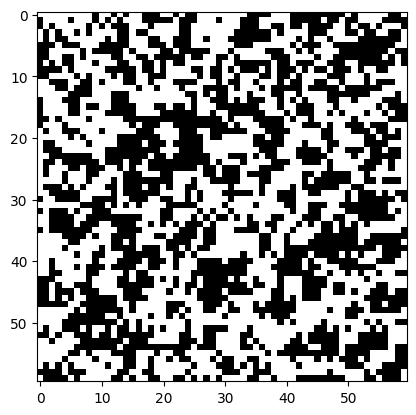

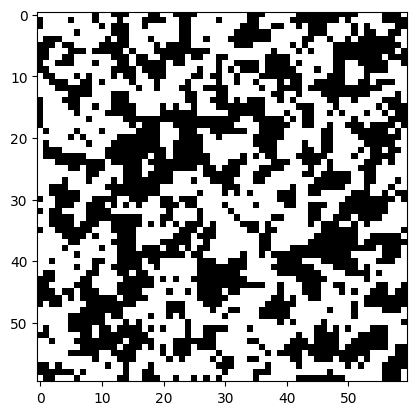

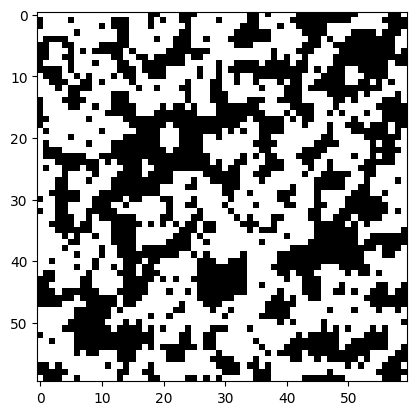

(512, 9)


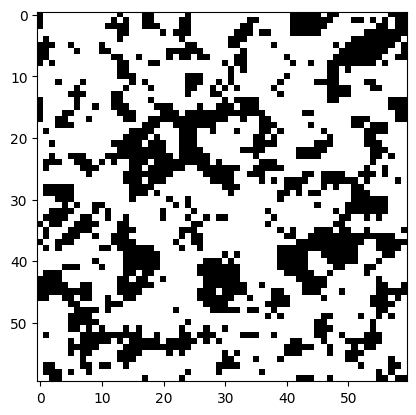

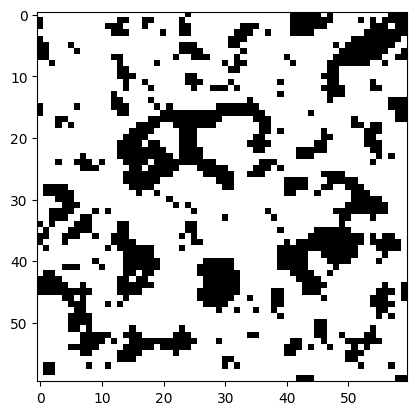

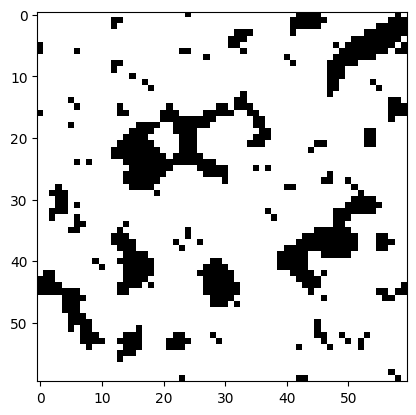

(512, 9)


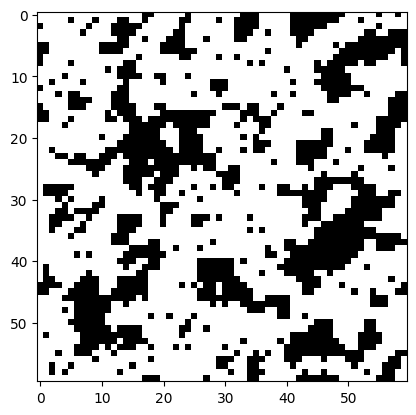

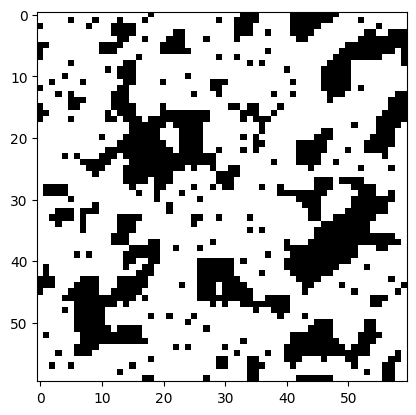

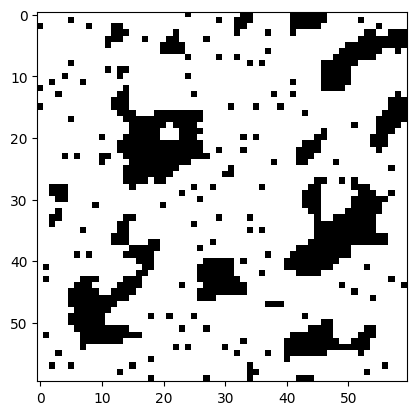

(512, 9)


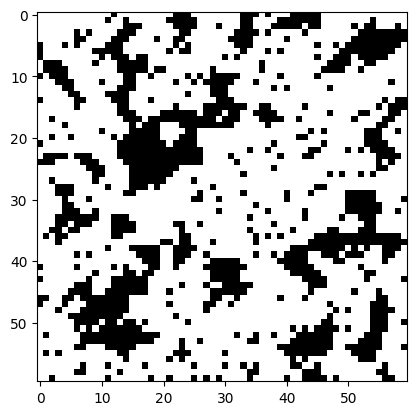

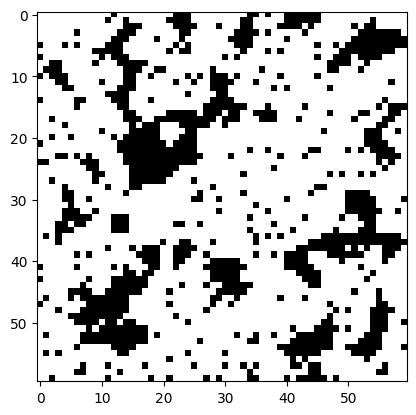

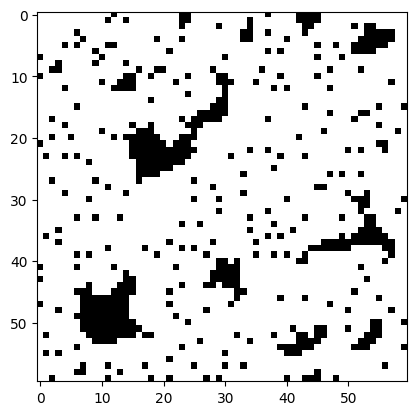

(512, 9)


In [ ]:
#MOTION_RULE

from sklearn.neural_network import MLPClassifier
import random
def vote_rule(n, c, t):
    state = n[1][1]
    if random.uniform(0., 1.) < 0.5:
      count = np.count_nonzero(n == 1) - state
      if count > 4 or (count == 4 and random.uniform(0., 2.) == 0.0):
        return 1
      else:
        return 0
    else:
      return state

clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(9, 9), max_iter = 10000) # убрал random_state = 1
experimentator = CellularAutomataExperimentator(clf, 60, 60, 2, vote_rule, 1, random_initial_state=True, distinct_training=False)
experimentator.experimentate_proba([2, 3, 4, 5, 6, 7, 8], 10, 'vote_rule')

In [ ]:
#CLUSTER

from sklearn.neural_network import MLPClassifier
import random
def cluster_rule(n, c, t):
    state = n[1][1]
    count = np.count_nonzero(n == 1) - state
    if state == 0 and count > 0 and random.uniform(0., 1.) < 0.5:
      return 1
    return state

clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(9, 9), max_iter = 10000) # убрал random_state = 1
experimentator = CellularAutomataExperimentator(clf, 5, 5, 2, cluster_rule, 1, random_initial_state=False, distinct_training=False)
experimentator.experimentate_proba([2, 3, 4], 10, 'cluster_rule', simple_initial_state=True)

In [ ]:
#CYCLIC

# the neighbourhood
# cell identity - the row and column indices of the cell in the cellular automaton matrix, as (row, col)
#  the time step
# current_activity = n[1][1]

# class CellularAutomataExperimentator:

#     def __init__(self, model, size_x, size_y, num_states, rule, rule_radius, random_initial_state, distinct_training):
def cyclic_rule(n, c, t):
    state = n[1][1]
    new_state = state
    k = (state + 1) % 3
    count = np.count_nonzero(n == k) - 1
    return k if count > 2 else state

from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(9, 9), max_iter = 10000)
experimentator = CellularAutomataExperimentator(clf, 10, 10, 3, cyclic_rule, 1, random_initial_state=True, distinct_training=False)
experimentator.experimentate([2, 4, 6, 8], 10, 'cyclic_rule')

norm  106.17438485811914
(100, 9)
(100, 9)
norm  93.86160024205851
(200, 9)
(196, 9)
norm  86.65448632355972
(400, 9)
(329, 9)
norm  83.01807032206904
(600, 9)
(348, 9)
norm  94.0584924395453
(800, 9)
(364, 9)
accuracy_rules
[0.5914748767972362, 0.6870395773002083, 0.7175735406188082, 0.747599451303155, 0.6878016562515876]
norm  104.43179592442141
(100, 9)
(100, 9)
norm  101.3804714922948
(200, 9)
(191, 9)
norm  99.61425600786265
(400, 9)
(293, 9)
norm  98.70663604844408
(600, 9)
(347, 9)
norm  99.25220400575496
(800, 9)
(386, 9)
accuracy_rules
[0.48280241833053905, 0.4975359447238734, 0.5165879185083575, 0.5277650764619215, 0.5304069501600366]
norm  113.93419153177855
(100, 9)
(100, 9)
norm  109.55363982999378
(200, 9)
(197, 9)
norm  112.0
(400, 9)
(307, 9)
norm  113.89468819923079
(600, 9)
(351, 9)
norm  112.9513169467271
(800, 9)
(359, 9)
accuracy_rules
[0.5129299395417366, 0.5626682924350963, 0.5351318396585887, 0.5133871869125641, 0.5242595132855764]
norm  94.33451118228153
(100, 

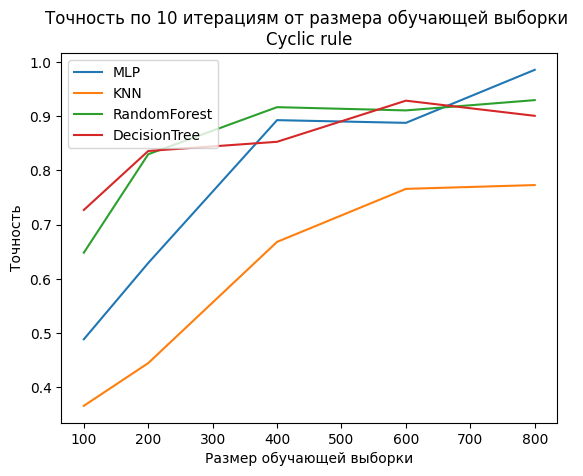

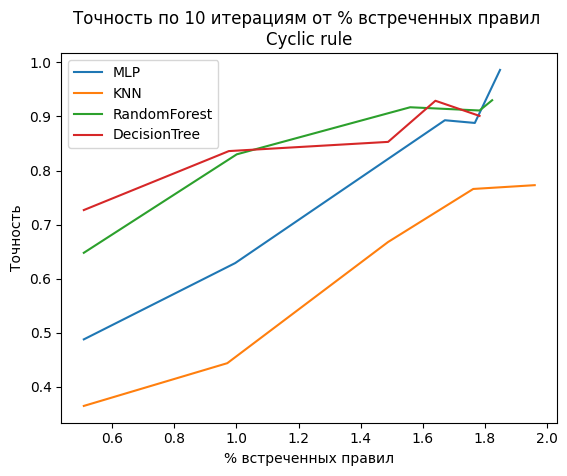

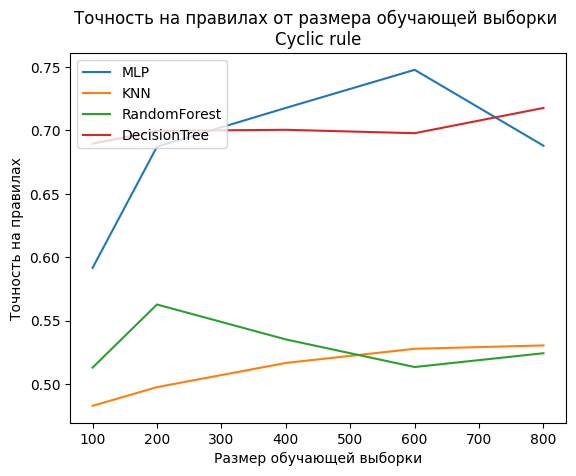

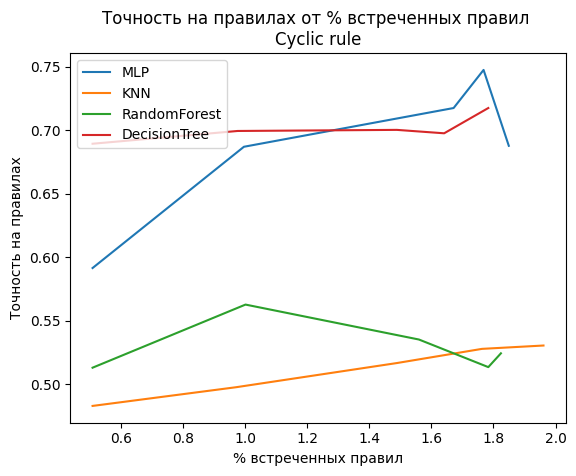

CPU times: user 6min 21s, sys: 6.55 s, total: 6min 28s
Wall time: 6min 26s


In [35]:
%%time
#CYCLIC comparison
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

clf_1 = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(9, 9), max_iter = 10000) # убрал random_state = 1
clf_2 = KNeighborsClassifier(n_neighbors=15)
clf_3 = RandomForestClassifier(n_estimators = 10, max_depth=2, random_state=0, n_jobs = 1)
clf_4 = DecisionTreeClassifier()

def cyclic_rule(n, c, t):
    state = n[1][1]
    new_state = state
    k = (state + 1) % 3
    count = np.count_nonzero(n == k) - 1
    return k if count > 2 else state

models = [clf_1, clf_2, clf_3, clf_4]
experimentator = CellularAutomataExperimentator(clf_1, 10, 10, 3, cyclic_rule, 1, random_initial_state=True, distinct_training=False)
experimentator.experimentate_model_aggr([1, 2, 4, 6, 8], 10, 4, 'Cyclic rule', models, labels=['MLP', 'KNN', 'RandomForest', 'DecisionTree'])

norm  9.746794344808963
(100, 9)
(94, 9)
norm  4.898979485566356
(200, 9)
(155, 9)
norm  0.0
(300, 9)
(195, 9)
norm  0.0
(400, 9)
(230, 9)
norm  0.0
(500, 9)
(251, 9)
norm  0.0
(600, 9)
(276, 9)
accuracy_rules
[0.814453125, 0.953125, 1.0, 1.0, 1.0, 1.0]
norm  10.677078252031311
(100, 9)
(94, 9)
norm  10.63014581273465
(200, 9)
(129, 9)
norm  9.9498743710662
(300, 9)
(158, 9)
norm  9.38083151964686
(400, 9)
(187, 9)
norm  9.486832980505138
(500, 9)
(195, 9)
norm  9.797958971132712
(600, 9)
(206, 9)
accuracy_rules
[0.77734375, 0.779296875, 0.806640625, 0.828125, 0.82421875, 0.8125]
norm  11.313708498984761
(100, 9)
(92, 9)
norm  10.295630140987
(200, 9)
(141, 9)
norm  9.643650760992955
(300, 9)
(186, 9)
norm  9.38083151964686
(400, 9)
(206, 9)
norm  9.327379053088816
(500, 9)
(226, 9)
norm  8.246211251235321
(600, 9)
(247, 9)
accuracy_rules
[0.75, 0.79296875, 0.818359375, 0.828125, 0.830078125, 0.8671875]
norm  11.532562594670797
(100, 9)
(97, 9)
norm  11.045361017187261
(200, 9)
(146, 9

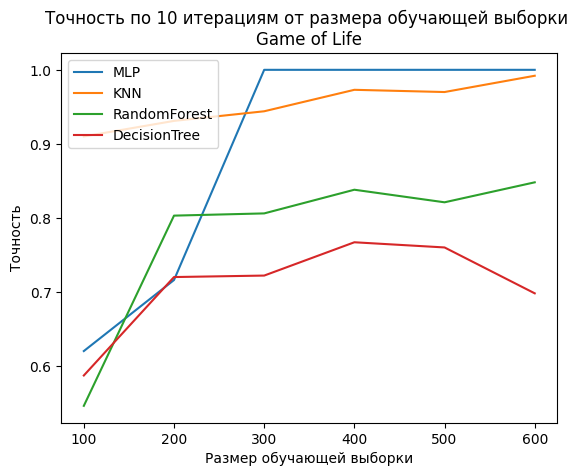

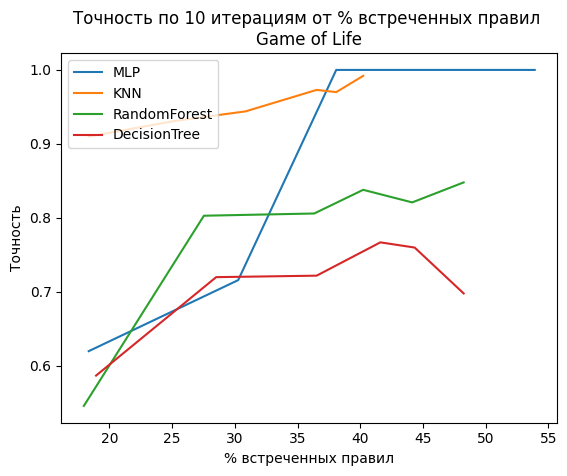

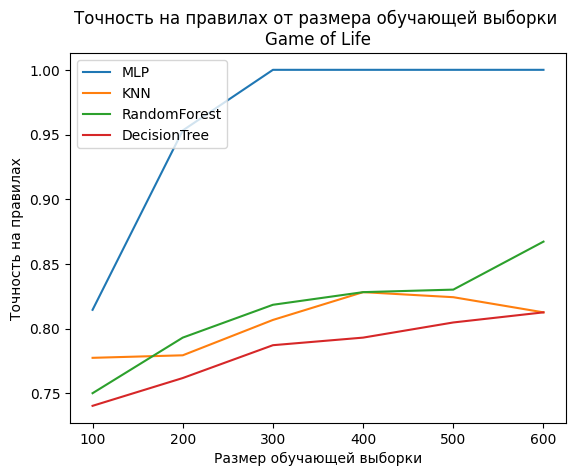

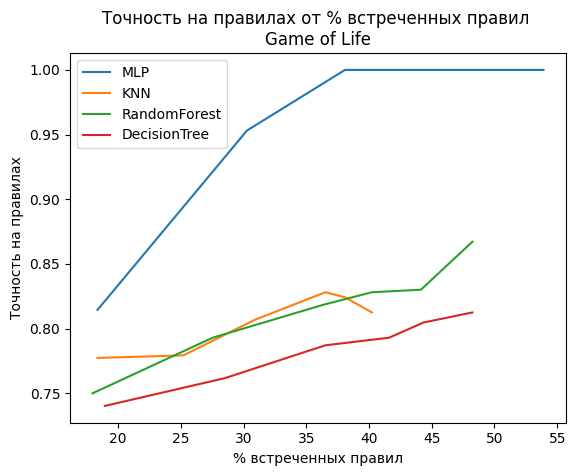

CPU times: user 34.9 s, sys: 414 ms, total: 35.3 s
Wall time: 35.5 s


In [51]:
%%time
#запуск для сравнения моделей для игры Жизнь
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

clf_1 = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(9, 9), max_iter = 10000) # убрал random_state = 1
clf_2 = KNeighborsClassifier(n_neighbors=9, weights='distance', algorithm='brute')
clf_3 = RandomForestClassifier(n_estimators = 10, max_depth=10, random_state=0, n_jobs = 1)
clf_4 = DecisionTreeClassifier(criterion='entropy')

models = [clf_1, clf_2, clf_3, clf_4]
experimentator = CellularAutomataExperimentator(clf_1, 10, 10, 2, cpl.game_of_life_rule, 1, random_initial_state=True, distinct_training=False)
experimentator.experimentate_model_aggr([1, 2, 3, 4, 5, 6], 10, 4, 'Game of Life', models, labels=['MLP', 'KNN', 'RandomForest', 'DecisionTree'])